## DASK_ML

In [1]:
import dask.dataframe as dd
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import xgboost as xgb
from dask.distributed import Client
import pandas as pd
import joblib
import numpy as np
import time
from dask.delayed import delayed
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# Initialize Dask client
client = Client(n_workers=8, threads_per_worker=1, memory_limit='4GB')

In [3]:
# Load multiple Parquet files
data = dd.read_parquet('parquet/*.parquet')

# print all columns and their data types
print(data.dtypes)

Summons Number                                 int64
Plate ID                             string[pyarrow]
Registration State                   string[pyarrow]
Plate Type                           string[pyarrow]
Issue Date                           string[pyarrow]
Violation Code                                 int64
Vehicle Body Type                    string[pyarrow]
Vehicle Make                         string[pyarrow]
Issuing Agency                       string[pyarrow]
Street Code1                                   int64
Street Code2                                   int64
Street Code3                                   int64
Vehicle Expiration Date              string[pyarrow]
Violation Location                           float64
Violation Precinct                             int64
Issuer Precinct                                int64
Issuer Code                                    int64
Issuer Command                       string[pyarrow]
Issuer Squad                         string[py

### Data Cleaning

In [4]:
# keep only the columns we need
columns_to_keep = [
    'Violation County',
    'Issue Date',
    'Violation Time',]

data = data[columns_to_keep]

# rename columns to remove spaces and make them lowercase
data = data.rename(columns={
    'Violation County': 'violation_county',
    'Issue Date': 'issue_date',
    'Violation Time': 'violation_time'
})

# fix the county names
remap_county_dict = {
    'K' : 'Brooklyn',
    'Q' : 'Queens',
    'NY': 'Manhattan',
    'QN': 'Queens',
    'BK': 'Brooklyn',
    'R' : 'Staten Island',
    'BX': 'Bronx',
    'ST': 'Staten Island',
    'MN': 'Manhattan',
    'KINGS': 'Brooklyn',
    'QNS': 'Queens',
    'BRONX': 'Bronx'
}
data['violation_county'] = data['violation_county'].map(remap_county_dict).astype('category')

# convert the Issue Date to a datetime object
data['issue_date'] = dd.to_datetime(data['issue_date'], format='%m/%d/%Y', errors='coerce')

# Remove 'A' and 'P' from the end of the time, add ' AM' or ' PM' accordingly
data['violation_time'] = data['violation_time'].str.slice(stop=-1) + ' ' + data['violation_time'].str.slice(start=-1).replace({'A': 'AM', 'P': 'PM'})

# Convert the Violation Time to a datetime object
data['violation_time'] = dd.to_datetime(data['violation_time'], format='%I%M %p', errors='coerce')

# create a new column for the day of the week the violation was issued
data['violation_day_week'] = data['issue_date'].dt.dayofweek

# create a new column for the day of the month the violation was issued
data['violation_day_month'] = data['issue_date'].dt.day

# create a new column for the month the violation was issued
data['violation_month'] = data['issue_date'].dt.month

# create a new column for the year the violation was issued
data['violation_year'] = data['issue_date'].dt.year

# keep only rows with valid year (2013-2024)
data = data[(data['violation_year'] >= 2013) & (data['violation_year'] <= 2024)]

# keep only rows with valid month (1-12)
data = data[(data['violation_month'] >= 1) & (data['violation_month'] <= 12)]

# drop all rows with missing values
data = data.dropna()

# create a new column for the hour of the day the violation was issued
data['violation_hour'] = data['violation_time'].dt.hour.astype('int32')

# drop the Issue Date and Violation Time columns
data = data.drop(columns=['violation_time'])

c:\Users\Blaz\Desktop\Faks\Magisterij\4-Semester\Big-Data_Course\.venv\Lib\site-packages\dask_expr\_collection.py:4160: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('violation_county', 'object'))

  warnings.warn(meta_warning(meta))


In [5]:
# drop county column
data = data.drop(columns=['violation_county'])

In [6]:
#print type of columns
print(data.dtypes)

issue_date             datetime64[ns]
violation_day_week              int32
violation_day_month             int32
violation_month                 int32
violation_year                  int32
violation_hour                  int32
dtype: object


In [7]:
# print head of the data
# print(data.head())

In [8]:
# reduce the dataset to an hourly level - count the number of violations per hour
data = data.groupby(['violation_year', 'violation_month', 'violation_day_month', 'violation_day_week', 'violation_hour']).size().reset_index()
data = data.rename(columns={0: 'violation_count'})

In [9]:
print(data.dtypes)

violation_year         int32
violation_month        int32
violation_day_month    int32
violation_day_week     int32
violation_hour         int32
violation_count        int64
dtype: object


In [10]:
# make new column of format ='%Y-%m-%d %H:%M:%S' for the datetime (for joining with weather data)
data['datetime'] = data['violation_year'].astype(str) + '-' + data['violation_month'].astype(str).str.zfill(2) + '-' + data['violation_day_month'].astype(str).str.zfill(2) + ' ' + data['violation_hour'].astype(str).str.zfill(2) + ':00:00'
data['datetime'] = dd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [11]:
print(data.dtypes)

violation_year                  int32
violation_month                 int32
violation_day_month             int32
violation_day_week              int32
violation_hour                  int32
violation_count                 int64
datetime               datetime64[ns]
dtype: object


In [12]:
# Group the data by month and count the number of violations
monthly_violations = data.groupby(data['datetime'].dt.to_period('M')).size()

2024-06-23 12:19:33,003 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0020ad848890db653d9c45ca4b1fdb70 initialized by task ('shuffle-transfer-0020ad848890db653d9c45ca4b1fdb70', 6) executed on worker tcp://127.0.0.1:54984
2024-06-23 12:19:42,881 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0020ad848890db653d9c45ca4b1fdb70 deactivated due to stimulus 'task-finished-1719137982.8702595'
2024-06-23 12:20:01,668 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0020ad848890db653d9c45ca4b1fdb70 initialized by task ('shuffle-transfer-0020ad848890db653d9c45ca4b1fdb70', 6) executed on worker tcp://127.0.0.1:54985
2024-06-23 12:20:10,525 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0020ad848890db653d9c45ca4b1fdb70 deactivated due to stimulus 'task-finished-1719138010.5243714'
2024-06-23 12:20:33,743 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 0020ad848890db653d9c45ca4b1fdb70 initialized by task ('shuffle-transfer-0020ad848890db

<Axes: xlabel='datetime'>

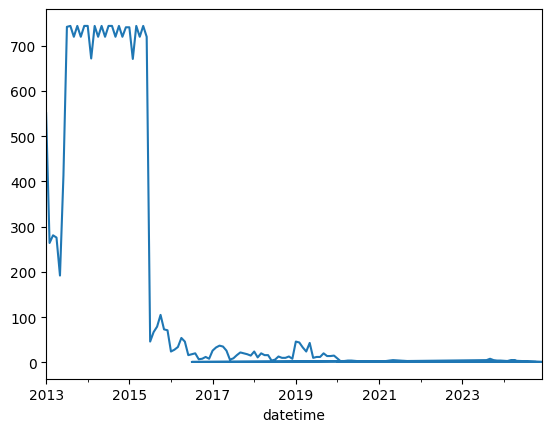

In [13]:
# Plot the monthly violations
monthly_violations.compute().plot()

In [14]:
# from the data take only the rows that have the datetime between 2013-01-01 and 2015-03-31
data = data[(data['datetime'] >= '2013-01-01') & (data['datetime'] <= '2015-03-31')]

In [15]:
print(data.dtypes)

violation_year                  int32
violation_month                 int32
violation_day_month             int32
violation_day_week              int32
violation_hour                  int32
violation_count                 int64
datetime               datetime64[ns]
dtype: object


In [16]:
# Step 1: Create a complete range of dates and hours directly with hourly frequency
min_date = data['datetime'].min().compute()
max_date = data['datetime'].max().compute()
print(f"Taking data from {min_date} to {max_date}")
all_date_hours = pd.date_range(start=min_date, end=max_date, freq='h').to_frame(index=False, name='datetime')

# Extract year, month, day_of_month, and day_of_week directly from the datetime
all_date_hours['violation_year'] = all_date_hours['datetime'].dt.year
all_date_hours['violation_month'] = all_date_hours['datetime'].dt.month
all_date_hours['violation_day_month'] = all_date_hours['datetime'].dt.day
all_date_hours['violation_day_week'] = all_date_hours['datetime'].dt.dayofweek
all_date_hours['violation_hour'] = all_date_hours['datetime'].dt.hour

# Step 2: Convert the comprehensive Pandas DataFrame to a Dask DataFrame
all_date_hours_dd = dd.from_pandas(all_date_hours, npartitions=10)

# Step 3: Merge with existing data using Dask's merge function
complete_data = dd.merge(all_date_hours_dd, data, on=['violation_year', 'violation_month', 'violation_day_month', 'violation_day_week', 'violation_hour'], how='outer')

# Fill missing values with 0
complete_data['violation_count'] = complete_data['violation_count'].fillna(0).astype(int)

Taking data from 2013-01-01 00:00:00 to 2015-03-31 00:00:00


In [17]:
# drop datetime_y column and rename datetime_x to datetime
complete_data = complete_data.drop(columns=['datetime_y'])
complete_data = complete_data.rename(columns={'datetime_x': 'datetime'})

In [18]:
# print columns
print(complete_data.dtypes)

datetime               datetime64[ns]
violation_year                  int32
violation_month                 int32
violation_day_month             int32
violation_day_week              int32
violation_hour                  int32
violation_count                 int64
dtype: object


## Augment Data

In [19]:
# Define the file path pattern to read all CSV files (adjust the path as needed)
file_pattern = 'nycweather_pesjak/nyc_w_*.csv'

# Specify the data types for each column
dtypes = {
    'datetime': 'str',  # 'datetime' will be parsed separately
    'temp': 'float64',
    'feelslike': 'float64',
    'dew': 'float64',
    'humidity': 'float64',
    'precip': 'float64',
    'precipprob': 'float64',
    'preciptype': 'object',  # String data type
    'snow': 'float64',
    'snowdepth': 'float64',
    'windgust': 'float64',
    'windspeed': 'float64',
    'winddir': 'float64',
    'sealevelpressure': 'float64',
    'cloudcover': 'float64',
    'visibility': 'float64',
    'solarradiation': 'float64',
    'solarenergy': 'float64',
    'uvindex': 'float64',
    'severerisk': 'float64',
    'conditions': 'object',  # String data type
    'icon': 'object',  # String data type
    'stations': 'object'  # String data type
}

# Read all CSV files into a single Dask DataFrame with specified dtypes
df = dd.read_csv(file_pattern, dtype=dtypes)

# Convert the 'datetime' column to datetime type
df['datetime'] = dd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

# Drop all string columns except 'datetime'
columns_to_keep = ['datetime'] + [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
df = df[columns_to_keep]





In [20]:
# print types of the columns
print(df.dtypes)

datetime            datetime64[ns]
temp                       float64
feelslike                  float64
dew                        float64
humidity                   float64
precip                     float64
precipprob                 float64
snow                       float64
snowdepth                  float64
windgust                   float64
windspeed                  float64
winddir                    float64
sealevelpressure           float64
cloudcover                 float64
visibility                 float64
solarradiation             float64
solarenergy                float64
uvindex                    float64
severerisk                 float64
dtype: object


## Join Data

In [21]:
# Merge the daily data with the weather data
augmented_data = data.merge(df, left_on='datetime', right_on='datetime', how='left')

# print(augmented_data.head())

In [22]:
# count the number of missing values in each column
print(augmented_data.isnull().sum().compute())

violation_year             0
violation_month            0
violation_day_month        0
violation_day_week         0
violation_hour             0
violation_count            0
datetime                   0
temp                       2
feelslike                  2
dew                        2
humidity                   2
precip                     2
precipprob                 2
snow                       2
snowdepth                  2
windgust               10822
windspeed                  2
winddir                    2
sealevelpressure           2
cloudcover                 2
visibility                 2
solarradiation             3
solarenergy                3
uvindex                    3
severerisk             17283
dtype: int64


In [23]:
# drop sewerisk and windgust column
augmented_data = augmented_data.drop(columns=['severerisk', 'windgust'])

# drop all rows with missing values
augmented_data = augmented_data.dropna()


In [24]:
# Temporal train-test split
split_date = '2014-12-31 23:00:00'
train_data = augmented_data[augmented_data['datetime'] < split_date]
test_data = augmented_data[augmented_data['datetime'] >= split_date]

X_train = train_data.drop(['violation_count'], axis=1)
y_train = train_data['violation_count']
X_test = test_data.drop(['violation_count'], axis=1)
y_test = test_data['violation_count']

# drop Issue Date column
X_train = X_train.drop(['datetime'], axis=1)
X_test = X_test.drop(['datetime'], axis=1)

# Identify constant columns in the training set
constant_columns = X_train.columns[X_train.nunique() <= 1]

# Drop constant columns from the training and test sets
X_train = X_train.drop(columns=constant_columns)
X_test = X_test.drop(columns=constant_columns)

# Convert Dask DataFrame to Dask Array
X_train_array = X_train.to_dask_array(lengths=True)
y_train_array = y_train.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)
y_test_array = y_test.to_dask_array(lengths=True)


In [25]:
# standardize the train data and apply the same transformation to the test data
mean = X_train_array.mean(axis=0)
std = X_train_array.std(axis=0)
X_train_array = (X_train_array - mean) / std
X_test_array = (X_test_array - mean) / std

### Linear Regression - Dask

In [26]:
lr = LinearRegression()

start_time = time.time()
lr.fit(X_train_array, y_train_array)
end_time = time.time()
lr_fit_time = end_time - start_time

start_time = time.time()
y_pred_lr = lr.predict(X_test_array)
end_time = time.time()
lr_predict_time = end_time - start_time

### XGBoost

In [27]:
# Model 2: XGBoost
dtrain = xgb.DMatrix(X_train.compute(), label=y_train.compute())
dtest = xgb.DMatrix(X_test.compute(), label=y_test.compute())
params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'eval_metric': 'rmse'
}

start_time = time.time()
bst = xgb.train(params, dtrain, num_boost_round=100)
end_time = time.time()
xgb_fit_time = end_time - start_time

start_time = time.time()
y_pred_xgb = bst.predict(dtest)
end_time = time.time()
xgb_predict_time = end_time - start_time

### SGD Regression

In [28]:
# Batch size for training
batch_size = 100

# Model 1: SGDRegressor
sgd = SGDRegressor()
incremental_sgd = Incremental(sgd)

# Fit the model in batches
start_time = time.time()
for i in range(0, len(X_train_array), batch_size):
    end = i + batch_size
    X_batch = X_train_array[i:end].compute()
    y_batch = y_train_array[i:end].compute()
    incremental_sgd.partial_fit(X_batch, y_batch)
end_time = time.time()
sgd_fit_time = end_time - start_time

start_time = time.time()
y_pred_sgd = incremental_sgd.predict(X_test_array.compute())
end_time = time.time()
sgd_predict_time = end_time - start_time

## Baseline

In [29]:
# Preditc the mean for all days
y_pred_mean = np.full(len(y_test_array), y_train.mean().compute())



In [30]:
# Evaluate models
def evaluate_model(y_test, y_pred):
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred)
    }


In [31]:
results_baseline = evaluate_model(y_test_array.compute(), y_pred_mean)
print('Baseline:', results_baseline)

Baseline: {'MAE': np.float64(814.0153861512006), 'RMSE': np.float64(1079.462478415174)}


In [32]:
# Evaluate models
def evaluate_model(y_test, y_pred):
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred)
    }

results_lr = evaluate_model(y_test_array.compute(), y_pred_lr.compute())
results_xgb = evaluate_model(y_test_array.compute(), y_pred_xgb)
results_sgd = evaluate_model(y_test_array.compute(), y_pred_sgd)

In [33]:
# Print results
print(f"{'Method':<20}{'MAE':<25}{'RMSE':<25}{'fit time [ms]':<15}{'predict time [ms]':<15}")
print(f"{f'Linear Regression':<20}{results_lr['MAE']:<25.2f}{results_lr['RMSE']:<25.2f}{lr_fit_time:<15.2f}{lr_predict_time:<15.2f}")
print(f"{f'XGBoost':<20}{results_xgb['MAE']:<25.2f}{results_xgb['RMSE']:<25.2f}{xgb_fit_time:<15.2f}{xgb_predict_time:<15.2f}")
print(f"{f'SGDRegressor':<20}{results_sgd['MAE']:<25.2f}{results_sgd['RMSE']:<25.2f}{sgd_fit_time:<15.2f}{sgd_predict_time:<15.2f}")
print("_"*100)
print(f"{'Baseline':<20}{results_baseline['MAE']:<25.2f}{results_baseline['RMSE']:<25.2f}{0:<15}{0:<15}")

Method              MAE                      RMSE                     fit time [ms]  predict time [ms]
Linear Regression   734.54                   1024.51                  1539.51        0.00           
XGBoost             339.79                   536.56                   0.68           0.00           
SGDRegressor        809.15                   1079.64                  4382.63        14.53          
____________________________________________________________________________________________________
Baseline            814.02                   1079.46                  0              0              
